## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
import random 
import torch
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, rmse
from darts.datasets import EnergyDataset
%matplotlib inline

# Set seeds for reproducability
torch.manual_seed(10)
random.seed(10)

2022-04-30 05:28:53 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.
/apps/local/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/apps/local/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/apps/local/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Inde

## Set Up Data

In [2]:
# Download csv files
train_df = pd.read_csv("../Datasets/train_data.csv")
test_df = pd.read_csv("../Datasets/test_data.csv")

# Get length of train and test
train_len = len(train_df)
test_len = len(test_df)

# Create dataframe with all data
all_df = train_df.append(test_df)

# Get first date of train and test
first_train_date = train_df["Date"][0]
first_test_date = test_df["Date"][0]

# Create new date range which has no gaps and set it as new column in all_df
date_range = pd.date_range(start=first_train_date, periods = len(all_df))
all_df["Date2"] = date_range


# Get the first date of the test data. (2018-12-17)
test_start_date = all_df.iloc[train_len]["Date2"]

<ipython-input-2-215ce1e9e9b4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(test_df)


In [3]:
filler = MissingValuesFiller()

# This is a timeseries dataframe with ALL values (both train and test)
all_series = filler.transform(
    TimeSeries.from_dataframe(all_df, "Date2", ["Open"])
).astype(np.float32)

## Set Up Model

In [4]:
# Example values for Demo
# Sequence Length / Lookback window of 70
# Forecast steps of 753

curr_seq_len = 70
curr_for_steps = 753
num_epochs = 200

In [5]:
# Create the NBEATS model
model_nbeats = NBEATSModel(
    input_chunk_length = curr_seq_len, # Lookback period
    output_chunk_length = curr_for_steps, # Forecast period
    generic_architecture=True, # Generic version of the model is used
    num_stacks=5, #10
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=num_epochs,
    nr_epochs_val_period=1,
    batch_size=150,
    model_name="nbeats_run",
    log_tensorboard=True,
    random_state=1
)

In [6]:
# Set up train and test series
train_series = all_series[:train_len]
test_series = all_series[(train_len - curr_seq_len):(train_len + curr_for_steps)]

# Set up a scaler
scaler = StandardScaler()
applyScaler = Scaler(scaler)
applyScaler.fit(train_series)

# Use same scaler on both train and test
scaled_train_series = applyScaler.fit_transform(train_series)
scaled_test_series = applyScaler.fit_transform(test_series)

## Train Model

In [7]:
model_nbeats.fit(scaled_train_series, 
                  val_series = scaled_test_series, 
                  verbose = True)

[2022-04-30 05:28:54,677] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2188 samples.
[2022-04-30 05:28:54,677] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2188 samples.
2022-04-30 05:28:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 2188 samples.
[2022-04-30 05:28:54,719] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-04-30 05:28:54,719] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-04-30 05:28:54 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
[2022-04-30 05:28:54,721] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Sanity Checking: 0it [00:00, ?it/s]

/home/kevin.toner/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Test Model

In [8]:
# Get the predictions for the test dates
pred_series = model_nbeats.historical_forecasts(
    scaled_test_series,
    start=pd.Timestamp(test_start_date), # The first test date
    forecast_horizon=1,
    stride=1, # Do every test day
    retrain=False,
    verbose=True
)

  0%|          | 0/753 [00:00<?, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

## Produce a graph

In [9]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    # Set u
    fig,ax = plt.subplots()
    fig.canvas.draw()
    
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)

    # Plot lines
    pred_series_inv.plot(label=("Predicted"), color="teal")
    ts_transformed.univariate_component(0).plot(label="True", color="darkorange")

    # Set up the labels and title
    plt.xlabel("Day", fontsize=14, fontweight="bold")
    plt.ylabel("Stock Price", fontsize=14, fontweight="bold")
    plt.title("Predicted Vs True Stock Prices", fontsize=14, fontweight="bold")
    
    # Make graph look nice
    ax.set_xticklabels(np.arange(0,len(pred_series),90));
    ax.grid(False)
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth("1")
    plt.xticks(rotation=0)
    plt.legend(frameon=True)

<ipython-input-9-2f36349510ff>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,len(pred_series),90));


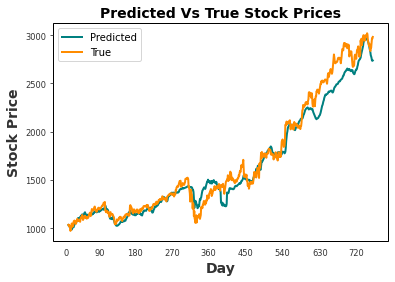

In [11]:
# Unscale everything
all_series_inv = applyScaler.inverse_transform(all_series)
test_series_inv = applyScaler.inverse_transform(scaled_test_series)
pred_series_inv = applyScaler.inverse_transform(pred_series)

if curr_for_steps == test_len:
    # Display a graph of predicted vs. actual
    display_forecast(pred_series_inv, test_series_inv[curr_seq_len:], "7 day")

## RMSE Results

In [12]:
# Get the RMSE value
rmse_value = round(rmse(test_series_inv[curr_seq_len:], pred_series_inv),3)
print("The RMSE value is:", rmse_value)

The RMSE value is: 112.864
